In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

from keras.layers import Dense,Input,Lambda
from keras.models import Model
from keras.metrics import binary_crossentropy
from keras.callbacks import LambdaCallback
import keras.backend as K
from keras.datasets import mnist

from jzl.datasets import emnist

from __future__ import print_function
from IPython.display import display

from ipywidgets import FloatProgress

/home/elijahc/.pyenv/versions/3.5.2/envs/jupyterlab/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from src.utils import process_mnist,gen_trajectory,gen_sorted_isomap
from src.models import build_dense,CachedModel
import bqplot.pyplot as bqp

In [3]:
# train the VAE on MNIST digits
(x_train, y_train,w_train), (x_test,y_test,w_test) = emnist.load_byclass()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
class_ids = np.unique(y_train)
masks_train = [y_train==i for i in class_ids]
masks_test = [y_test==i for i in class_ids]

digit_mask = lambda y: y<10 
uppercase = lambda y: (y>=10) & (y<36)
lowercase = lambda y: (y>=36) & (y<62)

input_shape=(784,)
print(x_train.shape)
print(x_test.shape)
# plt.imshow(x_train[masks[4]][10].reshape(28,28).T)

(697932, 784)
(116323, 784)


In [4]:
digits = digit_mask(y_test)
digits.shape

(116323,)

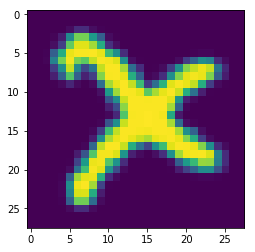

In [5]:
plt.imshow(x_train[lowercase(y_train)][90].reshape(28,28).T)

In [12]:
def train_autoencoder(model,train,test,mask=None,**kwargs):
    x_train,y_train = train
    x_test,y_test = test
    if mask is not None:
        X = x_train[mask(y_train)]
        V = (x_test[mask(y_test)],x_test[mask(y_test)])
    else:
        X = x_train
        V = (x_test,x_test)
    
    model.fit(X,X,validation_data=V,**kwargs)

In [13]:
encoding_dim = 32
latent_dim = 2
inputs = Input(shape=input_shape)
encoded = build_dense(inputs,[256,encoding_dim],activations='relu')

In [14]:
z_mean = Dense(latent_dim)(encoded)
z_log_sigma = Dense(latent_dim)(encoded)

def sampler(args):
    mean,log_stddev = args
    std_norm = K.random_normal(shape=(K.shape(mean)[0],latent_dim),mean=0,stddev=1)
    
    return mean + K.exp(log_stddev) * std_norm

lat_vec = Lambda(sampler)([z_mean,z_log_sigma])

In [15]:
decoded_mean = build_dense(lat_vec,[encoding_dim,256,784],activations=['relu','relu','sigmoid'])

In [16]:
upper_vae = Model(inputs,decoded_mean)
def vae_loss(input_img,output):
    # Reconstruction loss
    reconstruction_loss = K.sum(K.square(output-input_img))
#     kl_loss = -0.5*K.sum(1+z_log_sigma-K.square(z_mean)- K.square(K.exp(z_log_sigma)),axis=-1)
    total_loss = K.mean(reconstruction_loss)
    return total_loss
# vae.compile(loss=vae_loss,optimizer='rmsprop')
upper_vae.compile(loss=vae_loss,optimizer='adadelta')
# vae.summary()

In [17]:
train_autoencoder(upper_vae,(x_train, y_train),(x_test,y_test),mask=uppercase,
                  shuffle=True,
                  epochs=50,
                  batch_size=128)

Train on 188958 samples, validate on 31346 samples
Epoch 1/50
188958/188958 [==============================] - 13s 68us/step - loss: 6494.9604 - val_loss: 5809.1029
Epoch 2/50
188958/188958 [==============================] - 12s 66us/step - loss: 5727.3718 - val_loss: 5598.3280
Epoch 3/50
188958/188958 [==============================] - 13s 66us/step - loss: 5560.6129 - val_loss: 5470.1654
Epoch 4/50
188958/188958 [==============================] - 13s 66us/step - loss: 5440.1298 - val_loss: 5384.1789
Epoch 5/50
188958/188958 [==============================] - 13s 66us/step - loss: 5358.3874 - val_loss: 5313.0661
Epoch 6/50
188958/188958 [==============================] - 13s 66us/step - loss: 5280.8105 - val_loss: 5245.4700
Epoch 7/50
188958/188958 [==============================] - 13s 66us/step - loss: 5220.2069 - val_loss: 5186.4011
Epoch 8/50
188958/188958 [==============================] - 13s 66us/step - loss: 5193.8988 - val_loss: 5182.9351
Epoch 9/50
188958/188958 [===========

In [22]:
encoder = Model(inputs,z_mean)
decoder_inp = Input(shape=(latent_dim,))
dec_layers = upper_vae.layers[-3:]
_gen_x = dec_layers[0](decoder_inp)
_gen_x = dec_layers[1](_gen_x)
outputs = dec_layers[2](_gen_x)
generator = Model(decoder_inp,outputs)

In [19]:
x_test_encoded = encoder.predict(x_test[uppercase(y_test)],batch_size=128)

In [20]:
y_test_upper = y_test[uppercase(y_test)]

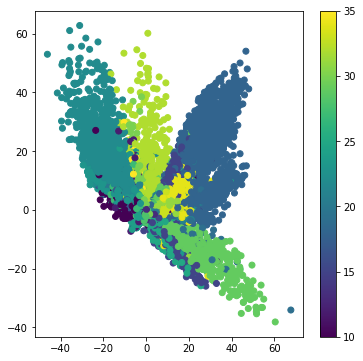

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],
            c=y_test_upper,
           )
plt.colorbar()
plt.show()

In [37]:
test_vals = [
    [20,20],
    [-20,20],
    [40,-20],
    [1,10],
    [1,15],
    [1,20]
]
test_vals = np.array(test_vals)

In [38]:
type(test_vals)

numpy.ndarray

[[22.945957   11.847066  ]
 [ 5.5671525  -0.08329277]
 [-0.52774674  0.12102075]
 [-1.7100648  -2.145562  ]
 [ 0.8504495   3.354458  ]]


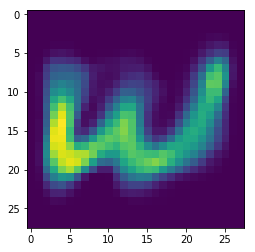

In [41]:
dec_test = generator.predict(test_vals)
print(x_test_encoded[:5])
plt.imshow(dec_test[5].reshape(28,28).T)